### Android Malware Detection Using ANN

In [ ]:
!pip install androguard

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import History
import pickle
from androguard.core.apk import APK

In [10]:
# Load dataset from CSV file
dataset_path = '/content/android_dataset-v1.csv'  # Change this to the path of your CSV file if needed
dataset_df = pd.read_csv(dataset_path)

# Encode labels and split dataset
Y = dataset_df['class']
X = dataset_df.drop(['class'], axis=1)
encoder = LabelEncoder().fit(Y)
Y = encoder.transform(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [11]:
# Define ANN model
AN = Sequential()
AN.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
AN.add(Dropout(0.2))
AN.add(Dense(128, activation='relu'))
AN.add(Dropout(0.2))
AN.add(Dense(128, activation='relu'))
AN.add(Dropout(0.2))
AN.add(Dense(32, activation='relu'))
AN.add(Dropout(0.2))
AN.add(Dense(1, activation='sigmoid'))
AN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Train ANN model with history callback to record metrics
history = History()
AN.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[history])

Epoch 1/100
17/17 [==============================] - 1s 17ms/step - loss: 0.6981 - accuracy: 0.4759 - val_loss: 0.6939 - val_accuracy: 0.4926
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5093 - val_loss: 0.6899 - val_accuracy: 0.5588
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.6849 - accuracy: 0.5500 - val_loss: 0.6861 - val_accuracy: 0.4853
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 0.6784 - accuracy: 0.5667 - val_loss: 0.6825 - val_accuracy: 0.4779
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.6726 - accuracy: 0.5778 - val_loss: 0.6787 - val_accuracy: 0.4779
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 0.6714 - accuracy: 0.5852 - val_loss: 0.6756 - val_accuracy: 0.5368
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.6657 - accuracy: 0.5870 - val_loss: 0.6727 - val_accuracy: 0.5441
Epoch 8/100


5/5 [==============================] - 0s 3ms/step - loss: 0.3959 - accuracy: 0.8382

loss: 39.59%

accuracy: 83.82%


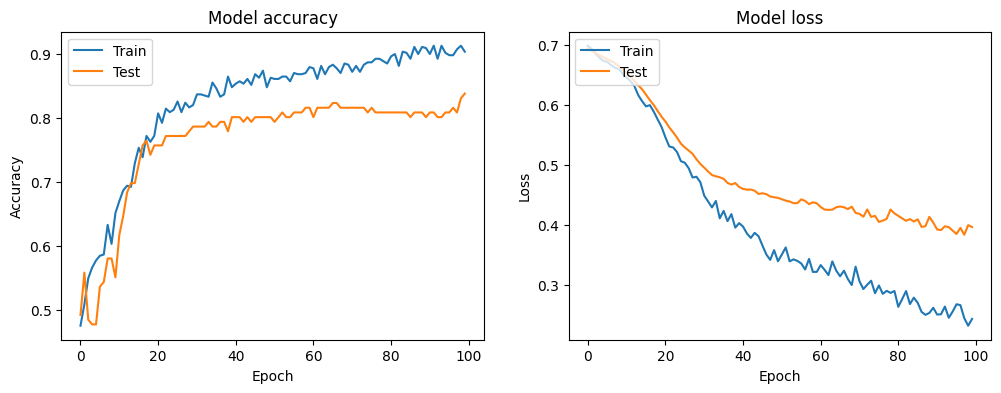

In [12]:
# Evaluate ANN model
scores = AN.evaluate(X_test, y_test)
for i in range(len(scores)):
    print("\n%s: %.2f%%" % (AN.metrics_names[i], scores[i]*100))

# Save ANN model
model_save_path = '/content/ANN_model.pkl'  # Change this to the path where you want to save your model
pickle.dump(AN, open(model_save_path, 'wb'))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

5/5 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        76
           1       0.82      0.82      0.82        60

    accuracy                           0.84       136
   macro avg       0.84      0.84      0.84       136
weighted avg       0.84      0.84      0.84       136

Confusion Matrix:
 [[65 11]
 [11 49]]


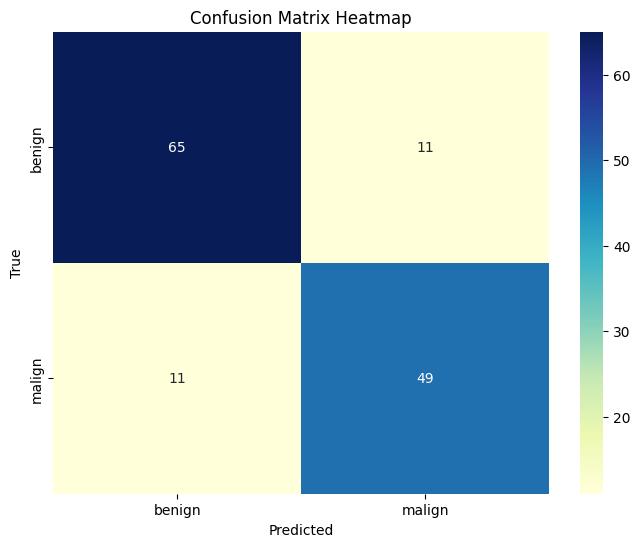

In [16]:
# Detailed performance metrics
y_pred = (AN.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plotting confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [17]:
# Load permissions list
permissions_path = '/content/permissions.txt'  # Update this path if needed
with open(permissions_path, 'r') as f:
    perms = [line.strip() for line in f]

# Define prediction function
def predict(apk, model, perms):
    vector = {}
    a = APK(apk)
    perm = a.get_permissions()
    for d in perms:
        vector[d] = 1 if d in perm else 0
    input = [v for v in vector.values()]
    prediction = model.predict([input])
    print(prediction)
    return prediction

In [ ]:
# Test predictions
malicious_apk_path = '/content/Calculator.apk'  # Change this to the path of a test malicious APK
benign_apk_path = '/content/com-application-zomato-1710017530-65268253-b55ca34c5369b65b15e4fe27d1cc71c8.apk'  # Change this to the path of a test benign APK

predict(malicious_apk_path, AN, perms)
predict(benign_apk_path, AN, perms)